#### Inspired by the work of:

https://medium.com/@tuennermann/convolutional-neural-networks-to-find-cars-43cbc4fb713

https://github.com/HTuennermann/Vehicle-Detection-and-Tracking

https://github.com/heuritech/convnets-keras

https://github.com/maxritter/SDC-Vehicle-Lane-Detection

#### 1. Config
This cell:
* Defines configuration variables for this IPython notebook.

In [1]:
# Visualisation parameters
display_output = 1     # Enables cell output visualisation

#### 2. Load test images

This cell:
* Loads all of the test images (supplied and generated by me) inside an images list (`img=[]`)
* Shows\saves a figure containing every test images.

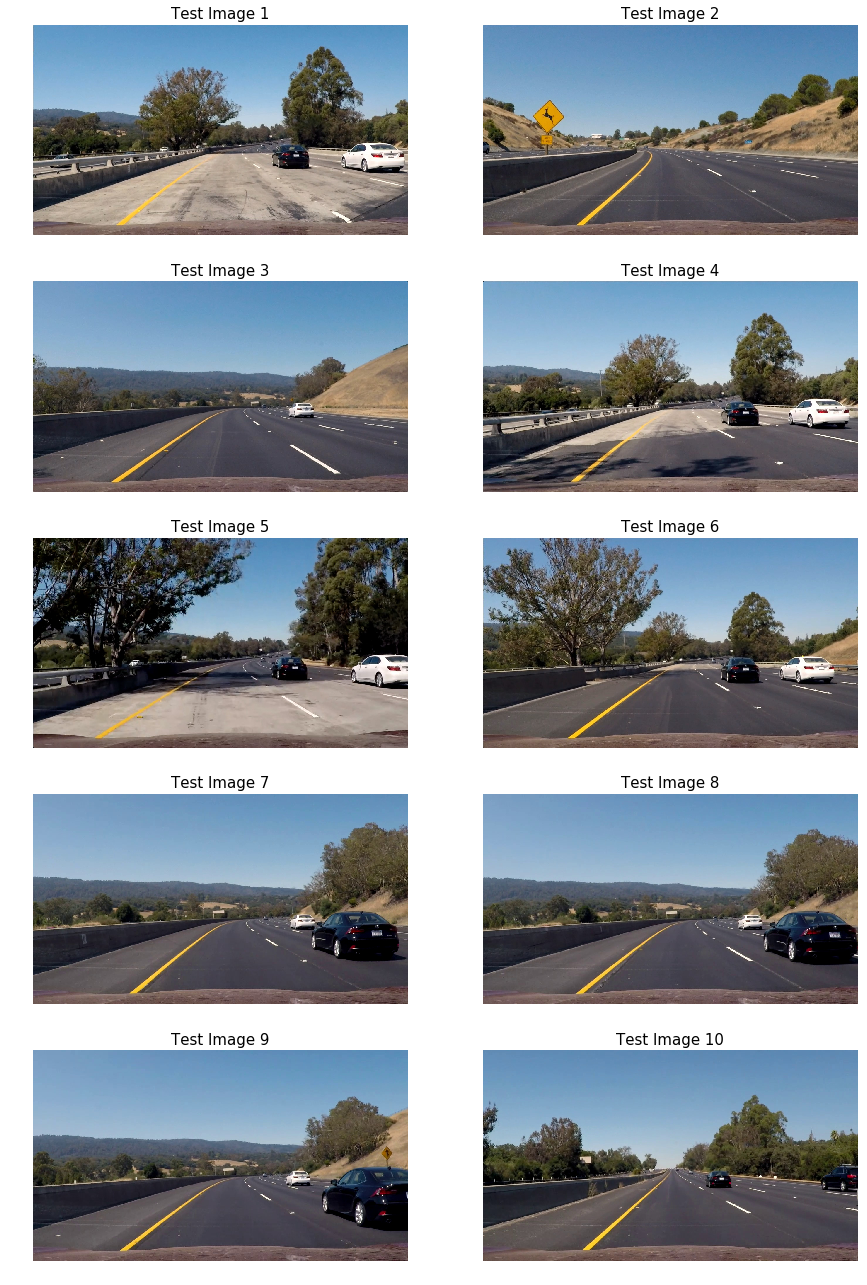

In [2]:
if display_output == 1:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    my_dpi = 94
    aspect_ratio = 16/9
    
    x_pix = 1200  # x dimension of resulting figure 
    col_num = 2
    test_img_num = 10
    
    row_num = int(test_img_num/col_num)

    img = {}
    f, ax = plt.subplots(row_num, col_num, 
                         figsize=(x_pix/my_dpi, x_pix/col_num*row_num/aspect_ratio/my_dpi))

    for i in range(test_img_num):
        img[i] = mpimg.imread('test_images/test' + str(i+1) + '.jpg')
        ax[int(i/col_num), i % col_num].imshow(img[i])
        ax[int(i/col_num), i % col_num].set_title('Test Image ' + str(i+1), fontsize=15)
        ax[int(i/col_num), i % col_num].axis('off')

    f.tight_layout()
    plt.savefig("./output_images/test_images.png", dpi=my_dpi)

#### 3. Plot regions of interest on test images
This cell:
* Defines a list (`rois`=[]) of the regions of interest (ROIs) that will be fed to the classifier.
* Computes a list (`scaling_roi=[]`) of scaling factors to be applied to the ROIs images in order to scale the feature to an order similar to the training features.
* Draws the ROIs over all of the test images and shows\save the resulting figure.

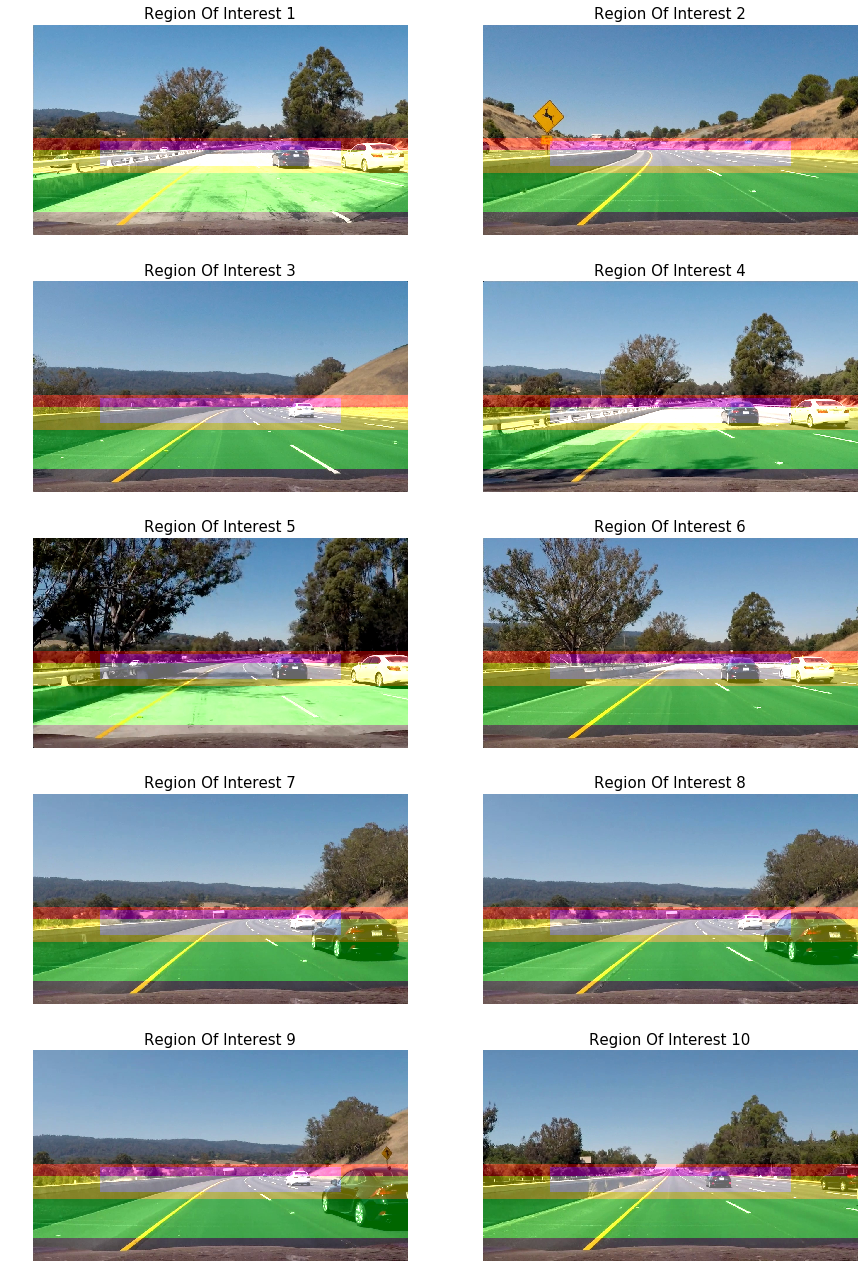

In [3]:
import numpy as np

# test images dimensions
h = 720
w = 1280 

# # Region of interest #1
# upper_left_roi_1 = (0, 390)
# lower_right_roi_1 = (1280, 640)

# # Region of interest #2
# upper_left_roi_2 = (0, 390)
# lower_right_roi_2 = (1280, 535)

# # Region of interest #3
# upper_left_roi_3 = (230, 400)
# lower_right_roi_3 = (1050, 483)

# Region of interest #1 (output heatmap heigth = 2)
upper_left_roi_1 = (0, 430)
lower_right_roi_1 = (1280, 640)

# Region of interest #2 (output heatmap heigth = 3)
upper_left_roi_2 = (0, 390)
lower_right_roi_2 = (1280, 506)

# Region of interest #3 (output heatmap heigth = 3)
upper_left_roi_3 = (230, 400)
lower_right_roi_3 = (1050, 483)


# ROIs (global variable)
rois = [(upper_left_roi_1, lower_right_roi_1),
        (upper_left_roi_2, lower_right_roi_2),
        (upper_left_roi_3, lower_right_roi_3)]

# Approx Car Height to detect in each ROI
car_h_1 = 100  #px
car_h_2 = 68  #px
car_h_3 = 40  #px

# Training dataset approx avg car height
car_h_train = 62 #px

# ROI scaling factors (global variable)
scaling_roi = [ car_h_train/car_h_1,   # 62/100 = 0.517  - 0.62
                car_h_train/car_h_2,   # 62/65 = 0.886   - 1.13
                car_h_train/car_h_3 ]  # 62/35  = 1.55  - 3.1

color = [(0,255,0),(255,0,0),(0,0,255)]

def draw_roi(img, roi, color):
    overlay1 = np.zeros_like(img).astype(np.uint8)
    cv2.rectangle(overlay1, roi[0], roi[1], color, -1)
    img_result = cv2.addWeighted(img, 1, overlay1, 0.4, 0)
    return img_result

def pipeline_roi(img):
    for i in range(len(rois)):
        img = draw_roi(img, rois[i], color[i])
    return img

if display_output == 1:
    import cv2
    
    x_pix = 1200  # x dimension of the resulting figure
    
#     x_pix = 2785 # 1:1 ratio images
    col_num = 2
    
    row_num = int(test_img_num/col_num)

    # Plot the result of applying the pipeline of undistorded images
    f, ax = plt.subplots(row_num, col_num, 
                         figsize=(x_pix/my_dpi, x_pix/col_num*row_num/aspect_ratio/my_dpi))

    for i in range(test_img_num):
        
        # Create an image to draw the ROI on
        img_result = pipeline_roi(img[i])

        ax[int(i/col_num), i % col_num].imshow(img_result)
        ax[int(i/col_num), i % col_num].set_title('Region Of Interest ' + str(i+1), fontsize=15)
        ax[int(i/col_num), i % col_num].axis('off')

    f.tight_layout()

    plt.savefig("./output_images/ROI.png", dpi=my_dpi)

#### 4. Use the trained classifier as a heatmap model
Since the model is made exclusively of convolution layers I do not need to actually specify image dimensions. By not adding the flatten() layer in the end, the output will be a feature map. Each pixel of this last feature map will act exactly the as the single output that was trained in *"P5-TrainModel.ipynb"* i.e.: 1 for Car and -1 for Not Car.

This cell:
* Loads the base "ConvNet" Model from "model.py" as `heatmodel`
* Displays the  model's summary

In [4]:
from model import get_model

# Get the "base" (without flatten layer) ConvNet Model
heatmodel = get_model(input_shape=(None, None, 3))

# Print out model summary
if display_output == 1:
    heatmodel.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 50)    1400      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 50)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 50)    22550     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 50)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 50)    22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 50)    0         
__________

#### 5. Load the classifier weights

This cell:
* Loads the pre-trained weights inside the `heatmodel`

In [5]:
# Load the weight
heatmodel.load_weights('./weights/best-weights.hdf5')
print("Weights loaded!")

Weights loaded!


#### 6. Lessons provided functions

This cell:
* Defines a `add_heat()` function which will be used to adds "heat" to a map from a list of bounding boxes. *[lesson 37]* 
* Defines a `apply_threshold()` function which will be used to discard cooler area of the heatmap. *[lesson 37]* 
* Defines a `draw_labeled_bboxes()` function which will be used to draw bounding boxes around the labeled regions returned by the `label()` function of SciPy (`scipy.ndimage.measurements`). *[lesson 37]*

In [6]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img

#### 7. Modified lessons provided functions

This cell:

* Defines a `find_cars()` function inspired by the function provided in lesson 35. but applied to the ConvNet output.

The `find_cars()` function inputs are the following:
* The raw ConvNet outputed heatmap
* A list of hot_windows (empty or not)
* The scaling to be applied
* The ROI coordinates

Based on the global variable `class_threshold`, the function adds bounding box coordinates to the `hot_windows` list (passed as a parameter). The coordinates are scaled and offseted to fit on the orignal image.

In [7]:
# Classification threshold
class_threshold  = 0.999

# Training dataset images dimension (ConvNet trained input dimension)
dataset_h = 64
dataset_w = 64

def find_cars(heatmap, hot_windows, scaling, roi):
    # Returns the ConvNet Output heatmap's coordinate matrices
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]), np.arange(heatmap.shape[1]))
    # Returns the hot pixels coordinates in x and y vectors
    x = (xx[heatmap[0,:,:,0] > class_threshold])
    y = (yy[heatmap[0,:,:,0] > class_threshold])

    # Scales hot window bounding box width and height
    hot_w_w = int(dataset_w/scaling)
    hot_w_h = int(dataset_h/scaling)
    
    # For each heatmap hotpixel coordinate in x,y vector, create the hot window upper_left and 
    # lower_right coordinate for the original image pixel space and append to the hot_windows list
    for i, j in zip(x, y):
        xpos = int((i*8)/scaling) + roi[0][0]   # int(coord_x/scaling  * (neural net scale down)) + crop_xmin
        ypos = int((j*8)/scaling) + roi[0][1]   # int(coord_y/scaling  * (neural net scale down)) + crop_ymin
        hot_windows.append(((xpos, ypos), (xpos + hot_w_w, ypos + hot_w_h)))

#### 8. Inference pipeline
This cell:
* Defines the `inference_pipeline()` function which returns the list of hot_windows

The `inference_pipeline()` function inputs are the following:
* The original image in which the function must detect cars
* The list of ROI scalings
* The list of ROIs coordinates

For each ROI, the function crops the image and scales it before feeding it to the `heatmodel` for inference. Then the `find_cars` function returns a list of `hot_windows` (window which are suceptible to contain cars) coordinates in the orignal image scaling.

/home/deep/miniconda2/envs/carnd-term1-gpu/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


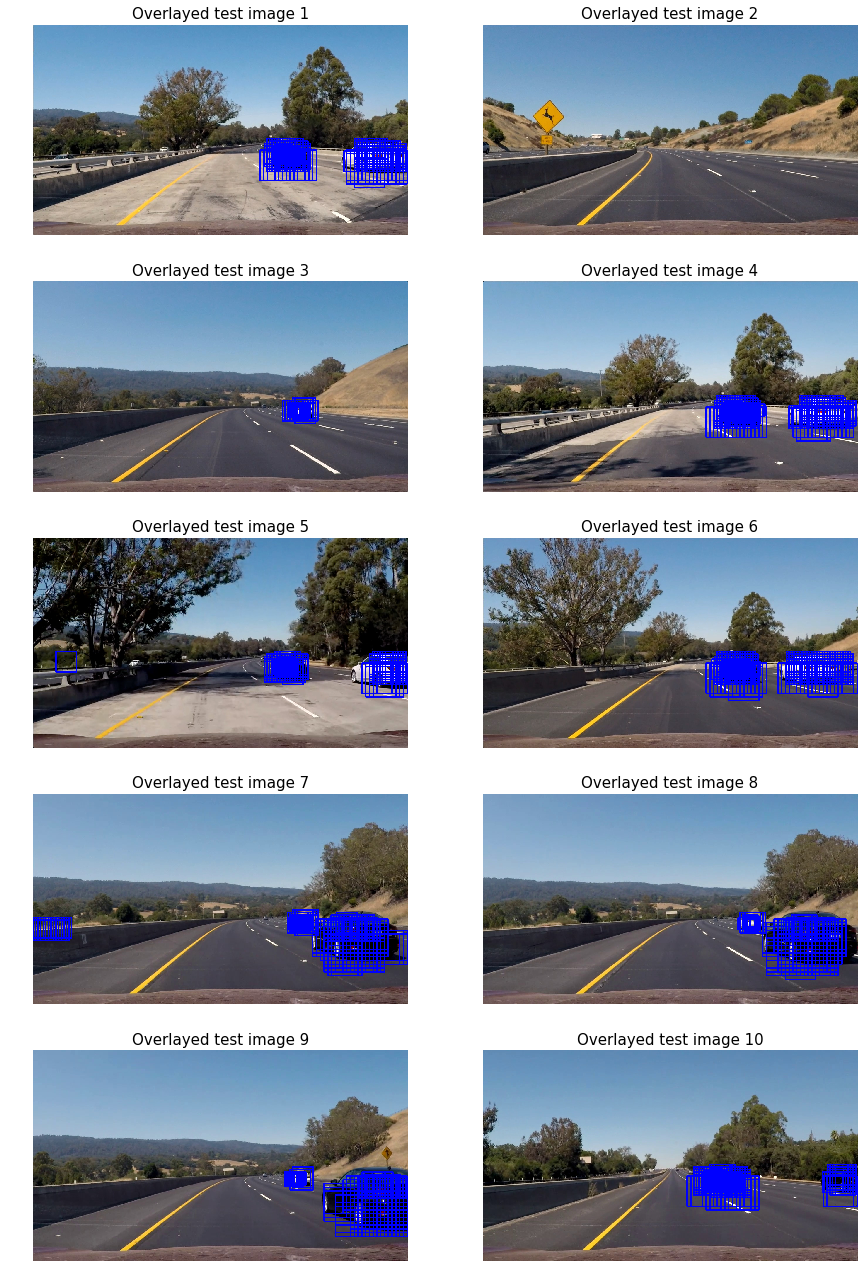

In [8]:
import cv2

def inference_pipeline(img, scaling_roi, rois):
    # Empty hot windows list
    hot_windows = []
    
    # For all the ROIs...
    for i in range(len(rois)):
        # Crop image along specified ROIs (see code cell #3 above)
        cropped = img[rois[i][0][1]:rois[i][1][1], rois[i][0][0]:rois[i][1][0]]
        
        # Resize the cropped image to fit the classifier trained scale
        resized = cv2.resize(cropped, None, fx=scaling_roi[i], fy=scaling_roi[i], interpolation=cv2.INTER_AREA)
   
        # Infere the heatmaps (Add one dimension to the image to fit the CNN input shape...)
        heatmap_infered = heatmodel.predict(resized.reshape(1,
                                                            resized.shape[0],
                                                            resized.shape[1],
                                                            resized.shape[2]))
        
        # Find hot windows coordinates in the original image space
        find_cars(heatmap_infered, hot_windows, scaling_roi[i], rois[i])
        
    return hot_windows

if display_output == 1:
    
    x_pix = 1200  # x dimension of the resulting figure 
    col_num = 2
    row_num = int(test_img_num/col_num)
    
    # Plot the result of applying the pipeline of undistorded images
    f, ax = plt.subplots(row_num, col_num, 
                         figsize=(x_pix/my_dpi, x_pix/col_num*row_num/aspect_ratio/my_dpi))

    for i in range(test_img_num):
        image = np.copy(img[i])
        
        # Call the inference pipeline
        hot_windows = inference_pipeline(image, scaling_roi, rois)
        
        # Draw the list windows over the original image
        for (upper_left, lower_right) in hot_windows:
            cv2.rectangle(image, upper_left, lower_right, (0,0,255), 4)
        
        ax[int(i/col_num), i % col_num].imshow(image)
        ax[int(i/col_num), i % col_num].set_title('Overlayed test image ' + str(i+1), fontsize=15)
        ax[int(i/col_num), i % col_num].axis('off')

    f.tight_layout()

    plt.savefig("./output_images/infered_bboxes.png", dpi=my_dpi)


#### 9. Modified heatmap (lessons provided) pipeline

This pipeline is based on lesson 37 example. The only difference is the addition of a stack that stores a number (`heatmap_history_length`) of the past frames heatmaps. Then these heatmaps are added together and thresholding and labeling is done on the sum.  This was done with the intent of smoothing out the detection process and reject a maximum of false positive detections.

In [9]:
import collections

# heatmap history length (5 frames = 1/6s)
heatmap_history_length = 5

# heat map threshold
heat_map_threshold = 18

# Declare a stack of heatmaps (stores the heatmap history)
heatmaps = collections.deque(maxlen=heatmap_history_length)

def heatmap_pipeline(image, hot_windows):
    
    # Create empty image similar to passed image
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in the hot list
    heat = add_heat(heat, hot_windows)
    
    # Add the heatmap on top of the stack (when full, the oldest heatmap is discarded)
    heatmaps.append(heat)
    heatmaps_sum = sum(heatmaps)
    
    # Apply threshold to help remove false positives
    heatmaps_sum = apply_threshold(heatmaps_sum, heat_map_threshold)

    # Visualize the heatmap when displaying (clip)   
    heatmap = np.clip(heatmaps_sum, 0, 255)
    
    # Find final bounding boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return heatmap, draw_img

#### 10. Detect cars on the test images

Two car detection pipelines are defined: the `debug_detection_pipeline()` outputs the heatmap while the other does not. Both are looking for hot windows that may contains cars with the help of the `inference_pipeline()` function and then updates the heatmap to draw bounding boxes on the original image with the `heatmap_pipeline()` function.

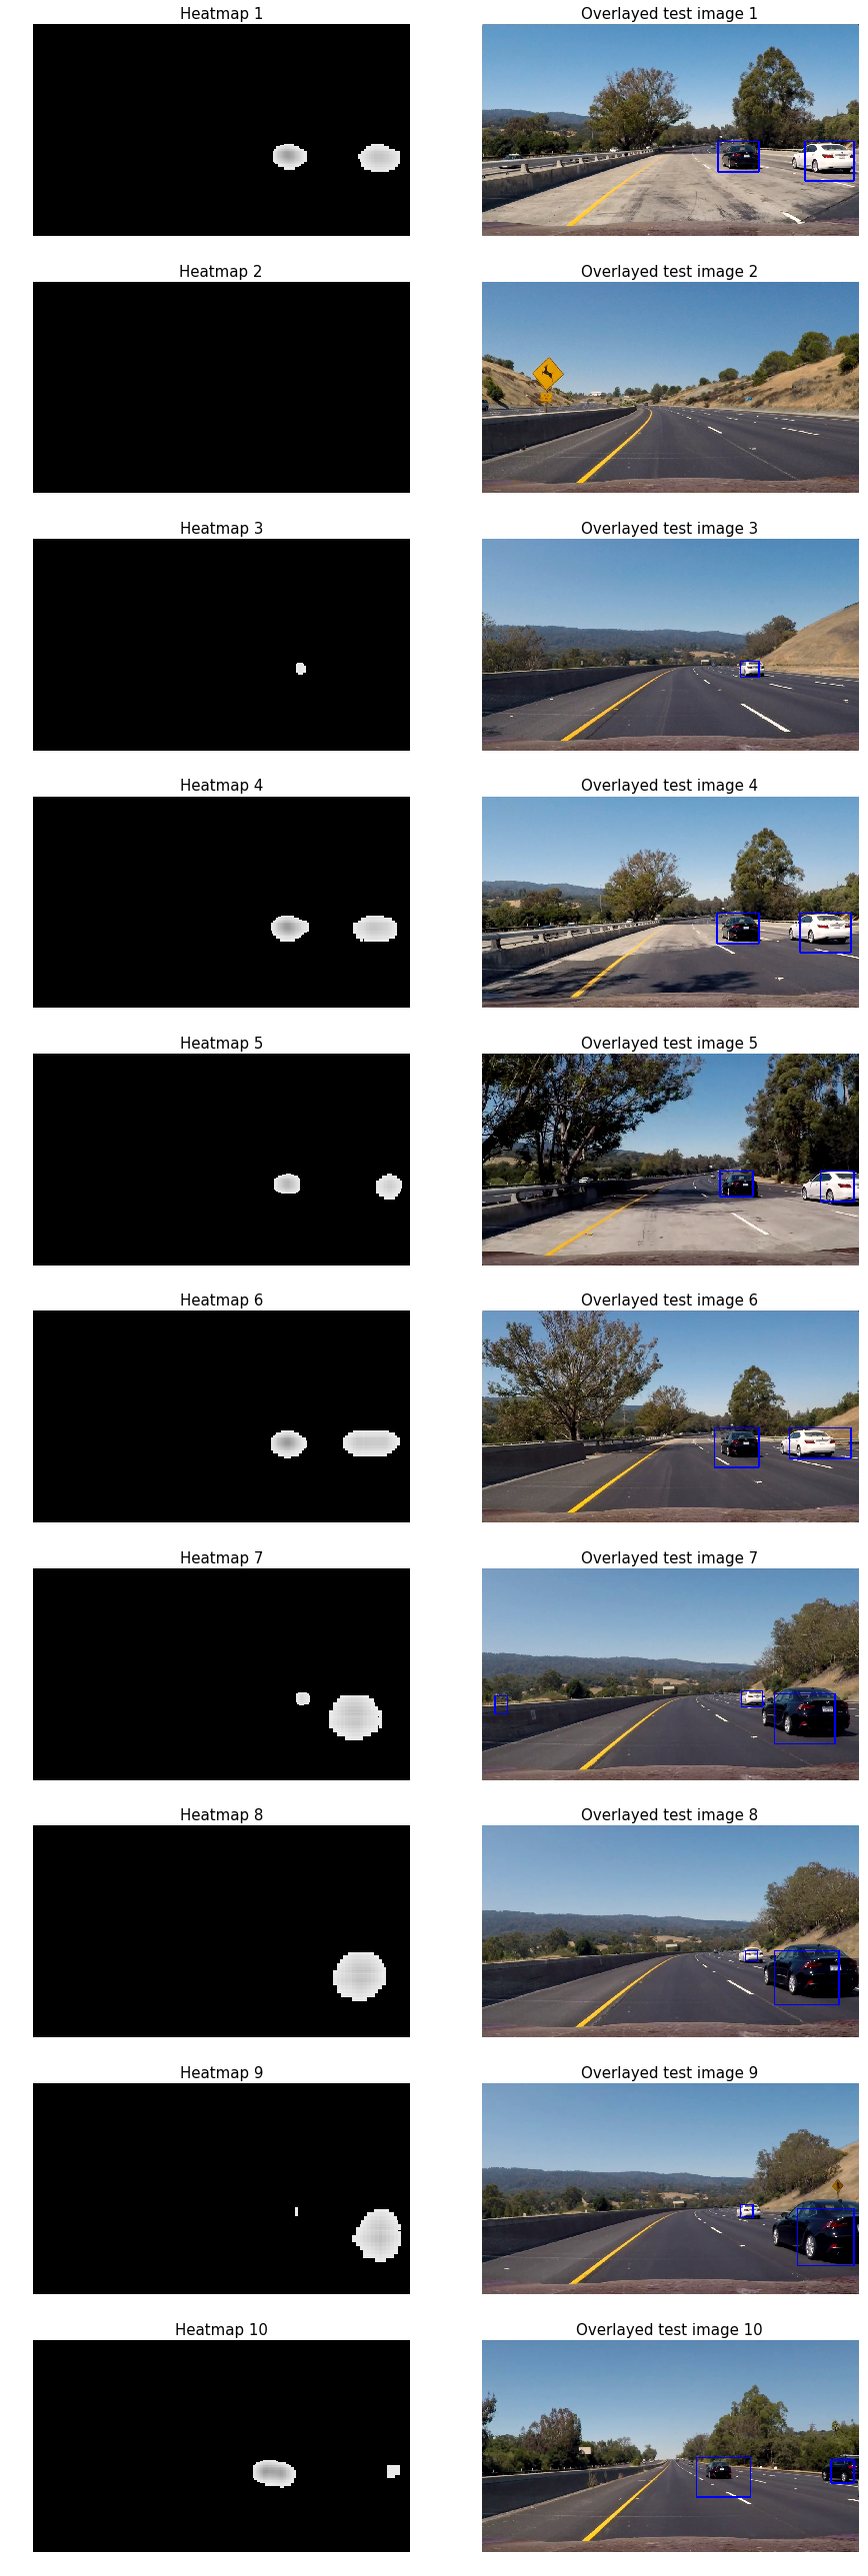

In [10]:
import cv2

def debug_detection_pipeline(img):
    # Finds hot windows suceptibles to contain a car (rois and scaling_roi, see cell #3)
    hot_windows = inference_pipeline(img, scaling_roi, rois)
    
    # Update the heatmap and draw the bounding boxes
    heatmap, draw_img = heatmap_pipeline(img, hot_windows)
    
    heatmap2 = heatmap.astype(np.uint8)
    
    heatmap3 = cv2.cvtColor(heatmap2, cv2.COLOR_GRAY2RGB)
    
    return heatmap3

def detection_pipeline(img):
    # Finds hot windows suceptibles to contain a car (rois and scaling_roi, see cell #3)
    hot_windows = inference_pipeline(img, scaling_roi, rois)
    
    # Update the heatmap and draw the bounding boxes
    heatmap, draw_img = heatmap_pipeline(img, hot_windows)
    
    return draw_img

if display_output == 1:
    
    x_pix = 1200  # x dimension of the resulting figure 
    col_num = 2
    row_num = test_img_num
    
    # Plot the result of applying the pipeline of undistorded images
    f, ax = plt.subplots(row_num, col_num, 
                         figsize=(x_pix/my_dpi, x_pix/col_num*row_num/aspect_ratio/my_dpi))

    for i in range(test_img_num):
        
        # Clear the heatmap history stack for each test image
        heatmaps.clear()
        
        # Call the Vehicle detection pipeline
        heatmap = debug_detection_pipeline(img[i])
        heatmap2 = heatmap.astype(np.float)
        img_result = detection_pipeline(img[i])
        
        ax[i, 0].imshow(heatmap2, cmap="gray")
        ax[i, 0].set_title('Heatmap ' + str(i+1), fontsize=15)
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(img_result)
        ax[i, 1].set_title('Overlayed test image ' + str(i+1), fontsize=15)
        ax[i, 1].axis('off')

    f.tight_layout()

    plt.savefig("./output_images/heatmaps_and_bbox.png", dpi=my_dpi)


#### 11. Test Video Processing

This cell processes the test video which is a lot shorter (great for testing).

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Clear the heatmaps stack before begining
heatmaps.clear()
project_output = './output_videos/test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_output.mp4
[MoviePy] Writing video ./output_videos/test_video_output.mp4


 97%|█████████▋| 38/39 [00:02<00:00, 18.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_output.mp4 

CPU times: user 10.5 s, sys: 116 ms, total: 10.6 s
Wall time: 2.54 s


#### 12. Project Video Processing

This cell processes the entire project video.

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Clear the heatmaps stack before begining
heatmaps.clear()
project_output = './output_videos/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(detection_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [01:18<00:00, 16.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 6min 39s, sys: 3.49 s, total: 6min 43s
Wall time: 1min 18s


In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Clear the heatmaps stack before begining
heatmaps.clear()
project_output = './output_videos/project_video_debug_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(debug_detection_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_debug_output.mp4
[MoviePy] Writing video ./output_videos/project_video_debug_output.mp4


100%|█████████▉| 1260/1261 [01:10<00:00, 17.71it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_debug_output.mp4 

CPU times: user 6min 34s, sys: 3.54 s, total: 6min 37s
Wall time: 1min 10s
